# Q4_ErblinMarku_210762815_NLP_ECS763P_ASSIGNMENT_1_SEQUENCE_CLASSIFICATION
# Assignment 1: CRF sequence tagging for Movie Queries

**NOTEBOOK/CODE SUBMISSION:

In [1]:
conda install -c conda-forge sklearn-crfsuite

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - sklearn-crfsuite


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2021.10.8          |   py39hf3d152e_1         145 KB  conda-forge
    python-crfsuite-0.9.7      |   py39h45ac560_1         193 KB  conda-forge
    sklearn-crfsuite-0.3.6     |     pyh9f0ad1d_0          12 KB  conda-forge
    tabulate-0.8.9             |     pyhd8ed1ab_0          26 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         375 KB

The following NEW packages will be INSTALLED:

  python-crfsuite    conda-forge/linux-64::python-crfsuite-0.9.7-py39h45ac560_1
  sklearn-crfsuite   conda-forge/noarch::sklearn-crfsuite-0.3.6-pyh9f0ad1d_0
  tabulate           conda-forge/noarch::tabulate-0.8.9-pyhd8ed1ab_0

The fo

In [3]:
import os
import sys


from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [4]:
def get_raw_data_from_bio_file(fpath):
    f = open(fpath)
    data = []  
    current_sent = [] 
    for line in f:
        if line == "\n": 
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [5]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt") 

In [6]:
# have a look at the first example
print(raw_training_data[0], "\n")

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')] 



In [7]:
# here I initialize the POS tagger
posttagger = CRFTagger()
posttagger.set_model_file("crf_pos.tagger")

In [8]:
def preProcess(example):
    #remove the second part of the tuple so I can get only the word
    singles=[w[0] for w in example]
    #here I apply the postagger to the words
    pos_singles = posttagger.tag(singles)
    #now I iterate in a for loop to get the word and the POS tag as the first part of tuple and the BIO tag as the second part of the tuple
    preprocessed_example = []
    for s, w in zip(pos_singles, example):
        preprocessed_example.append((w[0] + '@' + s[1],w[1]))
    return preprocessed_example

In [9]:
training_data = [preProcess(example) for example in raw_training_data]

In [10]:
# check the effect of pre-processing with the POS tagger
print(training_data[0],"\n")
print(training_data[1],"\n")

[('steve@PRPVBP', 'B-Actor'), ('mcqueen@VBN', 'I-Actor'), ('provided@VBN', 'O'), ('a@DT', 'O'), ('thrilling@NN', 'B-Plot'), ('motorcycle@NN', 'I-Plot'), ('chase@NN', 'I-Plot'), ('in@IN', 'I-Plot'), ('this@DT', 'I-Plot'), ('greatest@JJS', 'B-Opinion'), ('of@IN', 'I-Opinion'), ('all@DT', 'I-Opinion'), ('ww@NNP', 'B-Plot'), ('2@NNP', 'I-Plot'), ('prison@NNP', 'I-Plot'), ('escape@NN', 'I-Plot'), ('movies@NNS', 'I-Plot')] 

[('liza@NNP', 'B-Actor'), ('minnelli@NNP', 'I-Actor'), ('and@CC', 'O'), ('joel@NNP', 'B-Actor'), ('gray@NNP', 'I-Actor'), ('won@NNP', 'B-Award'), ('oscars@NNS', 'I-Award'), ('for@IN', 'O'), ('their@PRP$', 'O'), ('roles@NNS', 'O'), ('in@IN', 'O'), ('this@DT', 'O'), ('1972@NN', 'B-Year'), ('movie@NN', 'O'), ('that@WDT', 'B-Plot'), ('follows@VBZ', 'I-Plot'), ('nightclub@NN', 'I-Plot'), ('entertainers@NNS', 'I-Plot'), ('in@IN', 'I-Plot'), ('berlin@NNP', 'I-Plot'), ('as@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('nazis@NNS', 'I-Plot'), ('come@VBP', 'I-Plot'), ('to@TO', 'I-Plot'),

In [11]:
#imported the train_test_split from the sklearn data science library so I can use it to divide the data in two subsets used for training and testing
from sklearn.model_selection import train_test_split

""" - I used most train_test_split function when spliting the training data in two subsets.
    - Assigned the sizes of train data at 80% leaving the test data automatically at 20%.
    - Used only x_train and and x_test since our data is already in pairs of tuples format and I dont need to set data and target attributes to the training_data.
    - random_state is set to 0 because I want to see the changes in the training when I change the tagger"""

x_train, x_test =train_test_split(training_data, train_size=0.8, random_state=42)


#doing some tests so I can see if the split was succesful
#the outputs match the 80%-20% split.

print(len(training_data))
print(len(x_train))
print(len(x_test))
print(training_data[1],"\n")
print(x_train[1],"\n")
print(x_test[1],"\n")

7816
6252
1564
[('liza@NNP', 'B-Actor'), ('minnelli@NNP', 'I-Actor'), ('and@CC', 'O'), ('joel@NNP', 'B-Actor'), ('gray@NNP', 'I-Actor'), ('won@NNP', 'B-Award'), ('oscars@NNS', 'I-Award'), ('for@IN', 'O'), ('their@PRP$', 'O'), ('roles@NNS', 'O'), ('in@IN', 'O'), ('this@DT', 'O'), ('1972@NN', 'B-Year'), ('movie@NN', 'O'), ('that@WDT', 'B-Plot'), ('follows@VBZ', 'I-Plot'), ('nightclub@NN', 'I-Plot'), ('entertainers@NNS', 'I-Plot'), ('in@IN', 'I-Plot'), ('berlin@NNP', 'I-Plot'), ('as@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('nazis@NNS', 'I-Plot'), ('come@VBP', 'I-Plot'), ('to@TO', 'I-Plot'), ('power@VB', 'I-Plot')] 

[('what@WP', 'O'), ('2012@DT', 'B-Year'), ('movie@NN', 'O'), ('features@NNS', 'O'), ('a@DT', 'O'), ('struggling@NN', 'B-Plot'), ('screenwriter@NN', 'I-Plot'), ('who@WP', 'I-Plot'), ('gets@VBZ', 'I-Plot'), ('caught@VBN', 'I-Plot'), ('up@RP', 'I-Plot'), ('in@IN', 'I-Plot'), ('the@DT', 'I-Plot'), ('los@NNP', 'I-Plot'), ('angeles@NNP', 'I-Plot'), ('criminal@NNP', 'I-Plot'), ('underw

In [12]:
_pattern = re.compile(r"\d")
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    
    token = tokens[idx]
    feature_list = []
    #here I have to split again at the pos tagg
    pos_feature=token.split('@')
    token=pos_feature[0]
    feature_list.append("pTag_" + pos_feature[1])
    #create a var to store the split, and then split 
    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 6
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
    if len(token) > 4:
        feature_list.append("SUF_" + token[-4:])
    if len(token) > 5:
        feature_list.append("SUF_" + token[-5:])
    if len(token) > 6:
        feature_list.append("SUF_" + token[-6:])
    if len(token) > 1:
        feature_list.append("PRE_" + token[0])
    if len(token) > 2:
        feature_list.append("PRE_" + token[:2])
    if len(token) > 3:
        feature_list.append("PRE_" + token[:3])
    if len(token) > 4:
        feature_list.append("PRE_" + token[:4])
    if len(token) > 5:
        feature_list.append("PRE_" + token[:5])
    if len(token) > 6:
        feature_list.append("PRE_" + token[:6])  
   

    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [54]:
# Train the CRF BIO-tag tagger
#installed the python crfsuite and imported it here so we can use
import sklearn_crfsuite
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
#I try to modify the tagger function to get a better result by changing the training_opt
ct = CRFTagger(feature_func=get_features,training_opt={'c1':0.5,'c2':0.05, 'max_iterations':400, 'feature.possible_transitions': False})
#replace the training_data with x_train so we can train the 80% of the corpus
print("training tagger...")
ct.train(x_train, TAGGER_PATH)
print("done")

training tagger...
done


In [55]:
print("testing tagger...")
preds = []
y_test = []
for sent in x_test:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [56]:
# Output the classification report (which you should save each time for comparing your models)
classReport_afterSplit = classification_report(y_test, preds)
print(classReport_afterSplit)
print(precision_recall_fscore_support(y_test, preds, average='macro'))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.89      0.92      0.91       967
         B-Award       0.75      0.68      0.71        62
B-Character_Name       0.68      0.40      0.50       217
      B-Director       0.79      0.77      0.78       357
         B-Genre       0.82      0.77      0.79       684
       B-Opinion       0.47      0.39      0.43       165
        B-Origin       0.54      0.39      0.45       157
          B-Plot       0.49      0.44      0.47      1321
         B-Quote       0.37      0.37      0.37        19
  B-Relationship       0.72      0.49      0.58       134
    B-Soundtrack       0.25      0.09      0.13        11
          B-Year       0.96      0.97      0.97       500
         I-Actor       0.89      0.93      0.91      1179
         I-Award       0.76      0.85      0.80       124
I-Character_Name       0.64      0.40      0.50       141
      I-Director       0.82      0.78      0.80       316
         I-Ge

In [57]:
###### 5 Question #######
import pandas as pd
from sklearn.metrics import classification_report
report_dict3 = classification_report(y_test, preds, output_dict=True)
pd.DataFrame(report_dict3)

,B-Actor,B-Award,B-Character_Name,B-Director,B-Genre,B-Opinion,B-Origin,B-Plot,B-Quote,B-Relationship,...,I-Origin,I-Plot,I-Quote,I-Relationship,I-Soundtrack,I-Year,O,accuracy,macro avg,weighted avg
precision,0.892108,0.750000,0.682540,0.785714,0.821317,0.474074,0.535088,0.489983,0.368421,0.722222,...,0.659432,0.871041,0.372414,0.540000,0.333333,0.738095,0.858667,0.835241,0.651670,0.830268
recall,0.923475,0.677419,0.396313,0.770308,0.766082,0.387879,0.388535,0.444360,0.368421,0.485075,...,0.637097,0.923696,0.562500,0.431310,0.160000,0.794872,0.836543,0.835241,0.594285,0.835241
f1-score,0.907520,0.711864,0.501458,0.777935,0.792738,0.426667,0.450185,0.466058,0.368421,0.580357,...,0.648072,0.896596,0.448133,0.479574,0.216216,0.765432,0.847461,0.835241,0.613915,0.831493
support,967.000000,62.000000,217.000000,357.000000,684.000000,165.000000,157.000000,1321.000000,19.000000,134.000000,...,620.000000,12804.000000,96.000000,313.000000,25.000000,39.000000,11061.000000,0.835241,31889.000000,31889.000000


In [58]:
#Get the Precision values sorted for the analysis of False positives in Error Analysis 1, we sort and take the first 5 values.
pr= pd.DataFrame(report_dict3)
data1=pr.iloc[0,:]
sorted_precision = round(data1.sort_values(),3)
sorted_precision.iloc[0:5]

B-Soundtrack    0.250
I-Opinion       0.328
I-Soundtrack    0.333
B-Quote         0.368
I-Quote         0.372
Name: precision, dtype: float64

In [59]:
#looking at the top 5 categories with the lowest precision , 
#we have to deal with only 3 since the first 2 have 0 precision which means these categories dont have sentences
print("printing sentences")
categ=['B-Soundtrack','I-Soundtrack','B-Quote', 'I-Quote','I-Opinion']#use a list of our categories so we filter the others,'B-Quote', 

for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    #use n to limit the printing of sentences to only one time if more than one word happens to be a FP, which in our case happens a lot.
    n=2
    #I itereate and check for FP, which means the predicted tag found in one of our categories is different from than the tag in sent_true 
    for p, g, s in zip(predic,grt,sentences):
        if p not in categ:#focus only in the 3 categories we want
            continue
        if p != g:#check if it is FP
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FP is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p)) #And then all the word found in the above sentence which are FP with their prediction, ground truth and the word
print("done")

printing sentences
['in@IN', 'this@DT', 'film@NN', 'do@VBP', 'n@NNP', 't@NNP', 'steal@NNP', 'milton@NNP', 's@NNP', 'stapler@NNP', 'or@CC', 'he@PRP', 'just@RB', 'might@MD', 'make@VB', 'good@JJ', 'on@IN', 'his@PRP$', 'threat@NN', 'to@TO', 'burn@VB', 'the@DT', 'building@NN', 'down@IN']
GroundTruth:B-Plot->Predicted:B-Quote-->"do@VBP"
GroundTruth:I-Plot->Predicted:I-Quote-->"n@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"t@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"steal@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"milton@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"s@NNP"
GroundTruth:I-Plot->Predicted:I-Quote-->"stapler@NNP"
GroundTruth:O->Predicted:I-Quote-->"or@CC"
GroundTruth:O->Predicted:I-Quote-->"he@PRP"
GroundTruth:O->Predicted:I-Quote-->"just@RB"
GroundTruth:O->Predicted:I-Quote-->"might@MD"
GroundTruth:O->Predicted:I-Quote-->"make@VB"
GroundTruth:O->Predicted:I-Quote-->"good@JJ"
GroundTruth:O->Predicted:I-Quote-->"on@IN"
GroundTruth:O->Predicted:I-Quote-->"his@PRP$"
GroundT

In [60]:
#Get the recall values sorted for the analysis of False negatives in Error Analysis 2, we look at the 5 classes with lowest Recall values
rc= pd.DataFrame(report_dict3)
data2=rc.iloc[1,:]
sorted_recall = round(data2.sort_values(),3)
sorted_recall.iloc[0:5]

B-Soundtrack    0.091
I-Soundtrack    0.160
I-Opinion       0.189
B-Quote         0.368
B-Opinion       0.388
Name: recall, dtype: float64

In [61]:
print("printing sentences for the FN...")
categ=['I-Soundtrack','B-Soundtrack','I-Opinion','B-Quote', 'B-Character_Name']#use a list of our categories so we filter the others
for sent in x_test:
    grt = [s[1] for s in sent]
    predic = [x[1] for x in ct.tag([s[0] for s in sent])]
    sentences = [s[0] for s in sent]
    n=2
    for g, p, s in zip(grt,predic,sentences):
        if g not in categ:#focus only in the categories we want
            continue
        if g != p:#check if it is FN
            n-=1
            if n>0:
                print(sentences)#First I print the sentence where the FN is found
            print('GroundTruth:{1}->Predicted:{2}-->"{0}"'.format(s,g,p))
print("done")

printing sentences for the FN...
['what@WP', 'is@VBZ', 'the@DT', 'marvel@NN', 'comic@JJ', 'movie@NN', 'about@IN', 'the@DT', 'god@NNP', 'of@IN', 'thunder@NN', 'who@WP', 'comes@VBZ', 'to@IN', 'earth@NNP', 'and@CC', 'fights@NNS', 'his@PRP$', 'brother@NN', 'loki@NN']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"loki@NN"
['what@WP', 's@PDT', 'the@DT', 'kubrick@NN', 'film@NN', 'set@NN', 'in@IN', 'the@DT', 'future@NN', 'and@CC', 'involves@VBZ', 'alex@NN', 'and@CC', 'his@PRP$', 'band@NN', 'of@IN', 'thugs@NNS']
GroundTruth:B-Character_Name->Predicted:I-Plot-->"alex@NN"
['a@DT', 'clue@NN', 'a@DT', 'clue@NN', 'my@PRP$', 'kingdom@NN', 'for@IN', 'a@DT', 'clue@NN', 'about@IN', 'which@WDT', 'movie@NN', 'i@PRP', 'm@VBP', 'asking@VBG', 'about@IN']
GroundTruth:B-Quote->Predicted:B-Plot-->"a@DT"
['what@WP', '2010@NNP', 'movie@NNP', 'finds@NNP', 'superhero@NNP', 'alter@NNP', 'ego@NNP', 'tony@NNP', 'stark@NNP', 'once@RB', 'again@RB', 'battling@JJ', 'evil@NN', 'and@CC', 'saving@VBG', 'the@DT', 'day@NN'

In [62]:
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

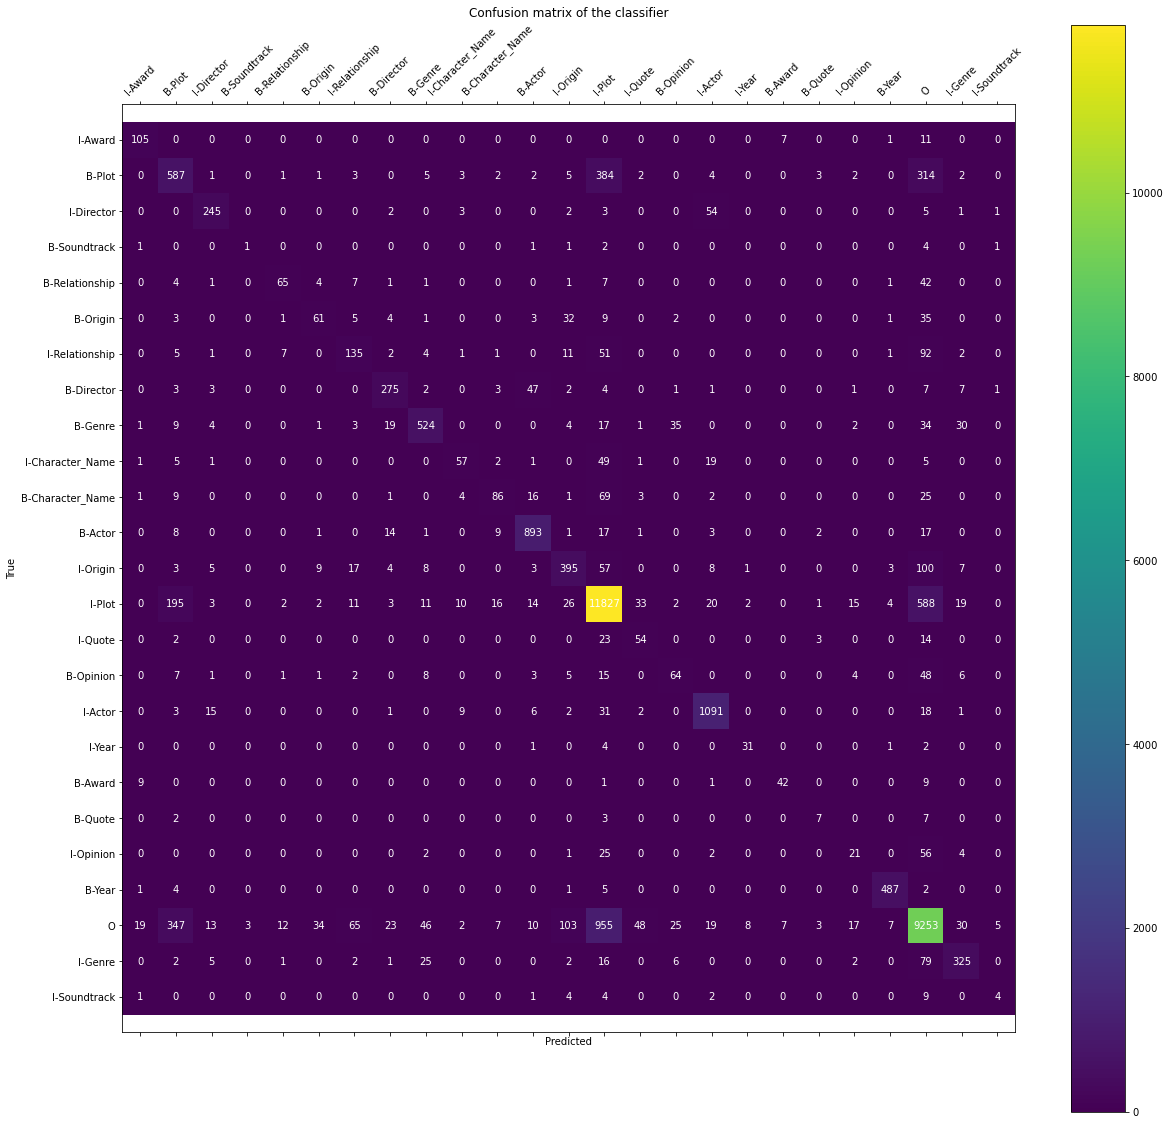

In [63]:
confusion_matrix_heatmap(y_test, preds)

In [64]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [65]:
print_transition_weights(ct._tagger.info().transitions.items())

12.085773 B-Actor  -> I-Actor
11.457648 B-Plot   -> I-Plot
10.998774 B-Quote  -> I-Quote
10.956292 B-Origin -> I-Origin
10.821051 B-Relationship -> I-Relationship
10.797749 B-Director -> I-Director
10.556101 I-Quote  -> I-Quote
10.240035 B-Award  -> I-Award
10.174245 B-Opinion -> I-Opinion
10.148641 I-Plot   -> I-Plot
9.994516 B-Soundtrack -> I-Soundtrack
9.930060 I-Opinion -> I-Opinion
9.795545 I-Origin -> I-Origin
9.746590 I-Relationship -> I-Relationship
9.542114 I-Soundtrack -> I-Soundtrack
9.506479 B-Character_Name -> I-Character_Name
9.361801 B-Genre  -> I-Genre
9.188853 I-Award  -> I-Award
8.869805 I-Genre  -> I-Genre
8.650248 I-Actor  -> I-Actor
8.236856 I-Character_Name -> I-Character_Name
7.797275 I-Director -> I-Director
7.666364 I-Year   -> I-Year
6.381994 B-Year   -> I-Year
5.245541 B-Character_Name -> B-Plot
5.064561 B-Plot   -> B-Character_Name
4.560970 I-Character_Name -> B-Plot
4.267059 B-Opinion -> B-Genre
4.146791 B-Actor  -> B-Plot
3.978699 I-Actor  -> B-Plot
3.9215

In [66]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    n=20 #added this counter to see only the top predicted features
    for (attr, label), weight in ranked_state_features:
        n-=1
        if n>0:
            print("%0.6f %-8s %s" % (weight, label, attr))

In [67]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

6.438457 I-Year   WORD_s
5.751237 B-Year   HAS_NUM
5.177303 B-Year   PRE_19
4.538065 B-Actor  WORD_cher
4.422488 B-Character_Name PRE_buz
4.352529 B-Genre  WORD_war
4.097096 B-Award  PRE_osc
4.068477 I-Actor  WORD_fat
4.063655 B-Award  PRE_os
4.045854 B-Character_Name WORD_hal
3.939899 B-Soundtrack WORD_i
3.833401 B-Genre  PRE_animat
3.727985 I-Quote  WORD_no
3.670419 B-Actor  WORD_fred
3.661894 B-Character_Name WORD_moe
3.646993 I-Genre  WORD_fi
3.598857 B-Actor  WORD_ray
3.562457 B-Character_Name WORD_bane
3.489037 I-Genre  WORD_war


In [68]:
#Write the above function to predict the least predictive features so I can see where to make improvements
def print_least_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=False) \
         if x[0][1] not in excluded_classes][:top_k]
    n=20
    for (attr, label), weight in ranked_state_features:
        n-=1
        if n>0:
            print("%0.6f %-8s %s" % (weight, label, attr))

In [69]:
print_least_predictive_state_features(ct._tagger.info().state_features.items())

-3.163785 I-Plot   SUF_car
-2.700809 I-Plot   SUF_lops
-2.557043 I-Actor  PRE_i
-2.430959 I-Plot   PRE_mont
-2.410340 I-Actor  PRE_pl
-2.265113 I-Genre  PRE_g
-2.214290 I-Plot   SUF_ron
-2.180770 B-Character_Name pTag_DT
-2.054138 I-Quote  WORD_and
-2.045867 I-Plot   SUF_u
-2.022330 I-Actor  SUF_ic
-2.007042 I-Plot   WORD_deals
-1.975965 I-Plot   SUF_rence
-1.969691 I-Plot   SUF_rad
-1.943907 I-Plot   PRE_jul
-1.941691 I-Director SUF_m
-1.936701 I-Actor  SUF_ing
-1.931563 I-Plot   WORD_part
-1.916980 I-Plot   SUF_pian


# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

In [70]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1953 instances
39035 words
training tagger...
done
1953 instances
39035 words
testing tagger on test data...
done


In [71]:
print(classification_report(y_test, preds))
print(precision_recall_fscore_support(y_test, preds, average='macro'))

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                  precision    recall  f1-score   support

         B-Actor       0.89      0.93      0.91      1274
         B-Award       0.71      0.71      0.71        66
B-Character_Name       0.66      0.36      0.46       283
      B-Director       0.85      0.77      0.81       425
         B-Genre       0.82      0.77      0.80       789
       B-Opinion       0.47      0.34      0.40       195
        B-Origin       0.53      0.39      0.45       190
          B-Plot       0.50      0.48      0.49      1577
         B-Quote       0.67      0.26      0.37        47
  B-Relationship       0.77      0.56      0.65       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.96      0.98      0.97       661
         I-Actor       0.88      0.93      0.91      1553
         I-Award       0.79      0.79      0.79       147
I-Character_Name       0.68      0.41      0.51       227
      I-Director       0.89      0.79      0.84       411
         I-Ge

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
